In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino Sans"

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## データ準備

In [2]:
df = sns.load_dataset("iris")
display(df.head())

df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

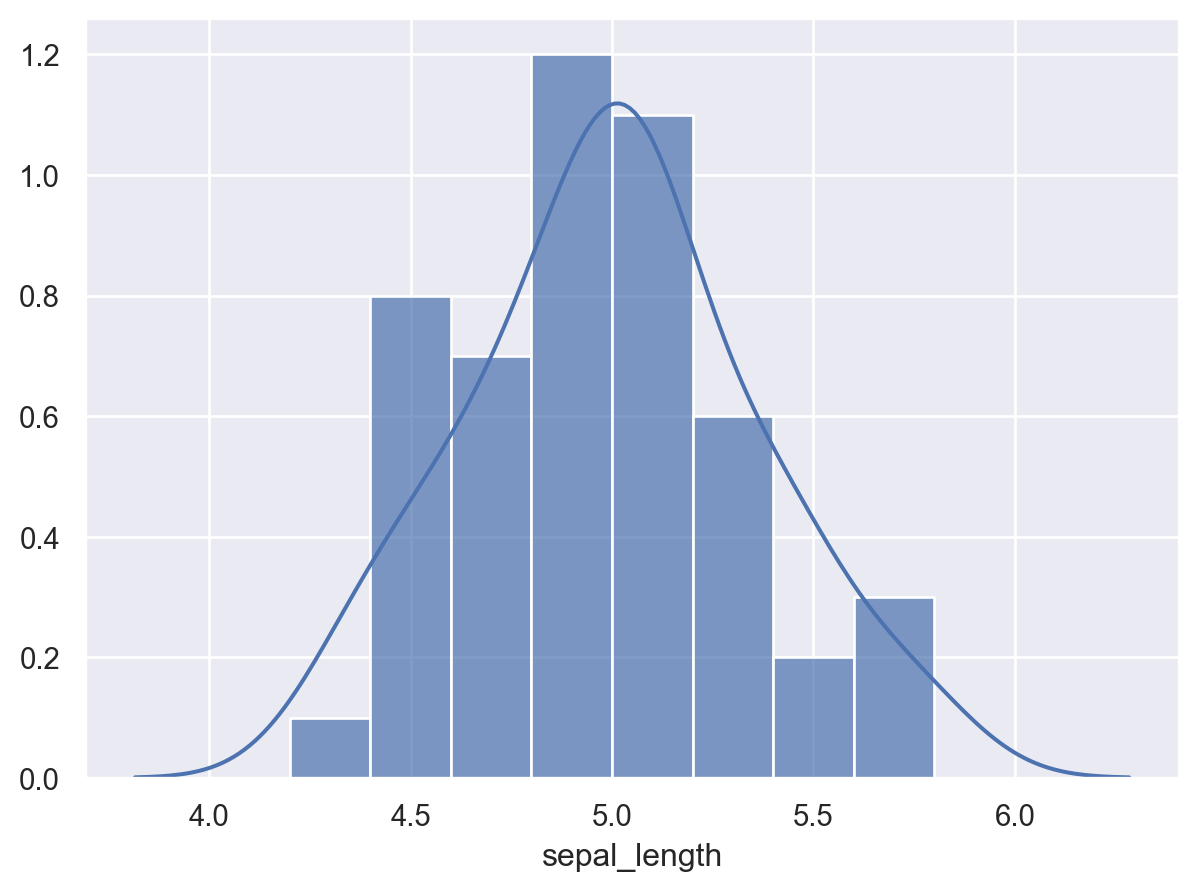

In [3]:
df1 = df[df["species"] == "setosa"]

(
    so.Plot(df1, x="sepal_length")
    .add(so.Bars(), so.Hist("density", bins=np.arange(4.0, 6.2, 0.2)))
    .add(so.Line(), so.KDE())
)

In [4]:
s1 = df1["sepal_length"]
print(s1.describe())

X = s1.to_numpy()
print(X)

count    50.00000
mean      5.00600
std       0.35249
min       4.30000
25%       4.80000
50%       5.00000
75%       5.20000
max       5.80000
Name: sepal_length, dtype: float64
[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5. ]


## 確率モデル定義

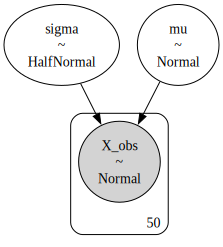

In [5]:
with pm.Model() as model1:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X)

g = pm.model_to_graphviz(model1)
display(g)

## サンプリング

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


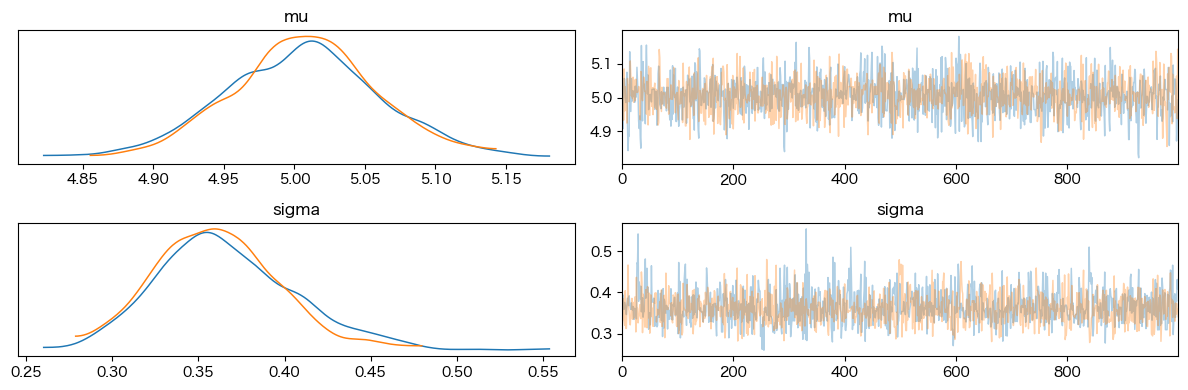

In [6]:
with model1:
    idata1 = pm.sample(random_seed=42, chains=2, draws=1000)

az.plot_trace(idata1, compact=False)
plt.tight_layout();

In [7]:
display(idata1)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

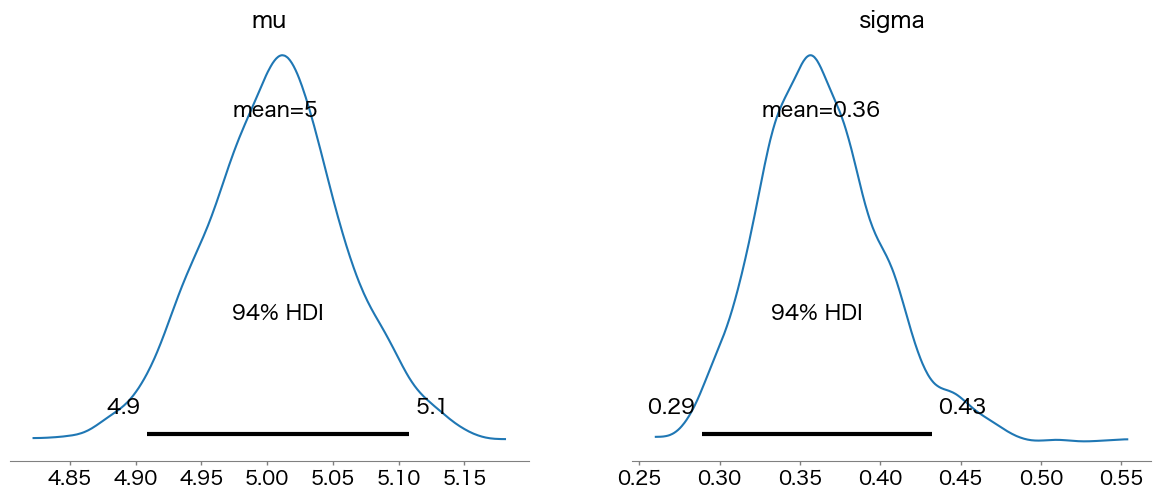

In [8]:
az.plot_posterior(idata1)

In [9]:
summary1 = az.summary(idata1)
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.006,0.053,4.908,5.108,0.001,0.001,1988.0,1081.0,1.00
sigma,0.364,0.038,0.289,0.432,0.001,0.001,1619.0,1201.0,1.01


In [10]:
mu_mean1 = summary1.loc["mu", "mean"]
sigma_mean1 = summary1.loc["sigma", "mean"]

print(f"mu={mu_mean1}, sigma={sigma_mean1}")

mu=5.006, sigma=0.364


## ヒストグラムと正規分布関数の重ね書き

In [11]:
def norm(x, mu, sigma):
    y = (x - mu) / sigma
    a = np.exp(-(y**2) / 2)
    b = np.sqrt(2 * np.pi) * sigma
    return a / b

In [12]:
x_min, x_max = X.min(), X.max()
x_list = np.arange(x_min, x_max, 0.01)
y_list = norm(x_list, mu_mean1, sigma_mean1)

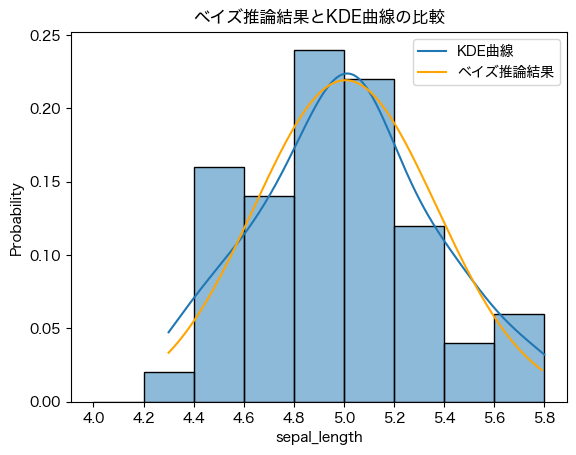

In [13]:
delta = 0.2
bins = np.arange(4.0, 6.0, delta)
fig, ax = plt.subplots()

sns.histplot(df1, ax=ax, x="sepal_length", bins=bins, kde=True, stat="probability")
ax.get_lines()[0].set_label("KDE曲線")
ax.set_xticks(bins)
ax.plot(x_list, y_list * delta, c="orange", label="ベイズ推論結果")
ax.set_title("ベイズ推論結果とKDE曲線の比較")
plt.legend();

## 少ないサンプル数でのベイズ推論

In [14]:
X_less = X[:5]
print(X)
print(pd.Series(X_less).describe())

[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5. ]
count    5.000000
mean     4.860000
std      0.207364
min      4.600000
25%      4.700000
50%      4.900000
75%      5.000000
max      5.100000
dtype: float64


In [15]:
with pm.Model() as model2:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X_less)

    idata2 = pm.sample(random_seed=42, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

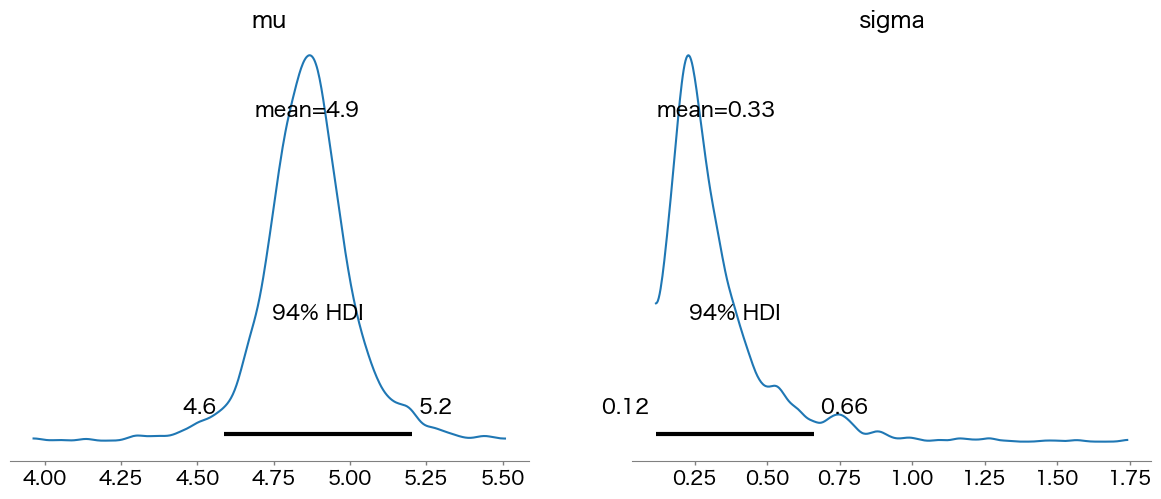

In [16]:
az.plot_posterior(idata2)

In [17]:
summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.859,0.160,4.586,5.202,0.006,0.004,727.0,681.0,1.0
sigma,0.325,0.183,0.116,0.662,0.008,0.006,603.0,874.0,1.0


# tau による確率モデルの定義

In [18]:
with pm.Model() as model3:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfNormal("tau", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    idata3 = pm.sample(random_seed=42, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

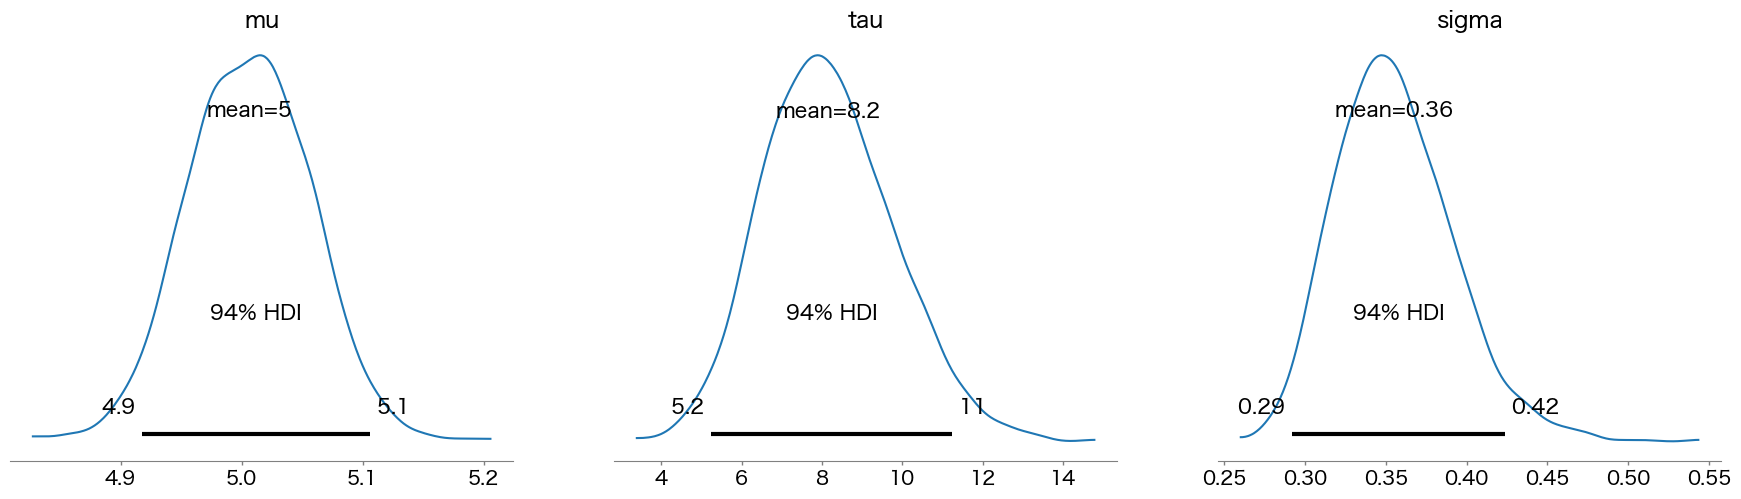

In [19]:
az.plot_posterior(idata3)

# 線形回帰のベイズ推論

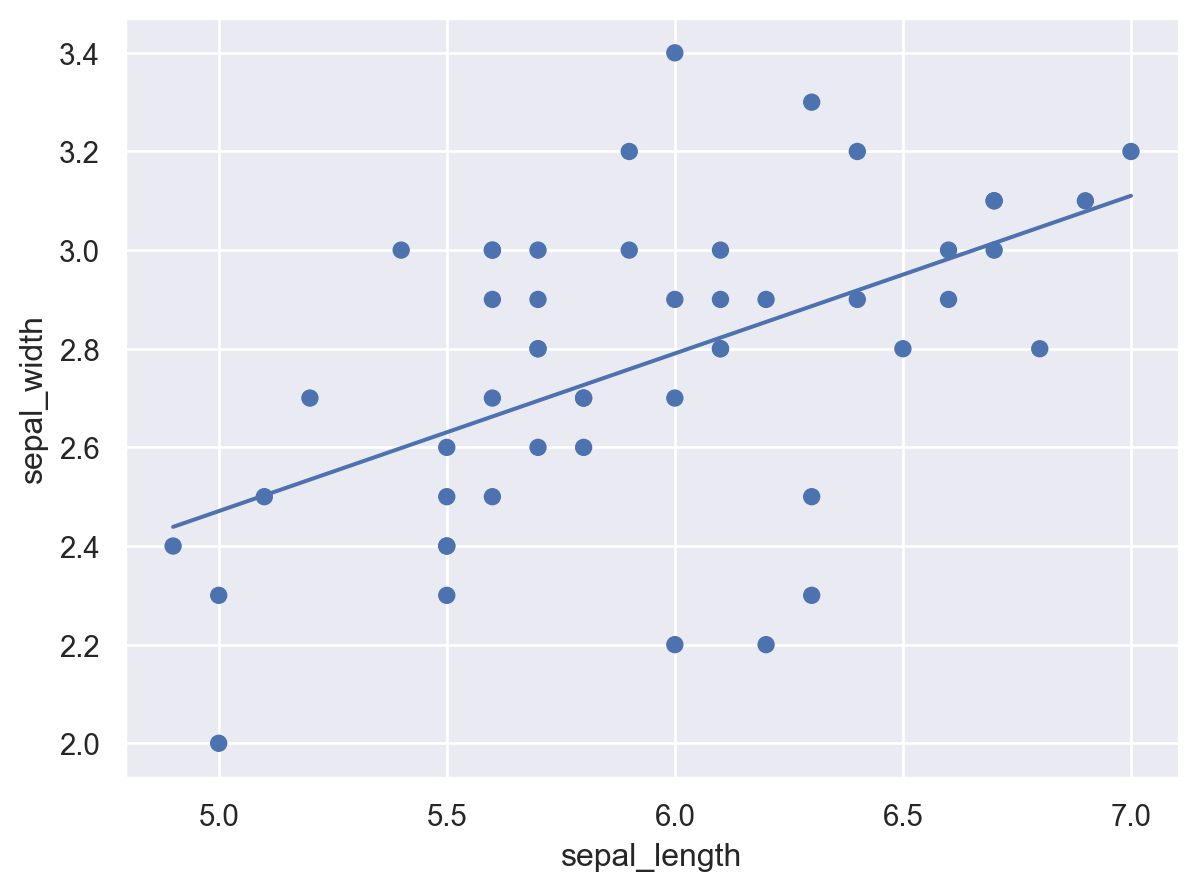

In [20]:
df2 = df[df["species"] == "versicolor"]
X = df2["sepal_length"]
Y = df2["sepal_width"]

(
    so.Plot(x=X, y=Y)
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

## 確率モデル定義 1
$$
Y_n = \alpha X_n + \beta + \epsilon_n
$$

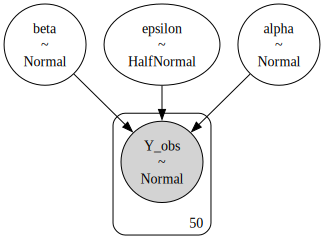

In [21]:
with pm.Model() as model4:
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=mu, sigma=10)
    mu = alpha * X + beta
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)

g = pm.model_to_graphviz(model4)
display(g)

## 確率モデル定義 2

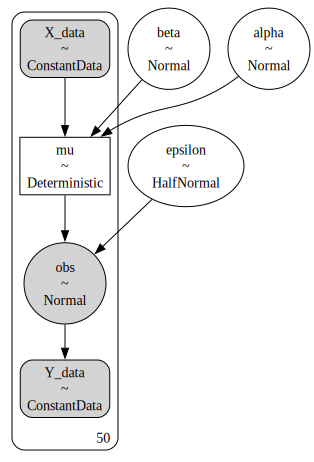

In [22]:
with pm.Model() as model5:
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)
    mu = pm.Deterministic("mu", alpha * X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

g = pm.model_to_graphviz(model5)
display(g)

## サンプリングと結果分析

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


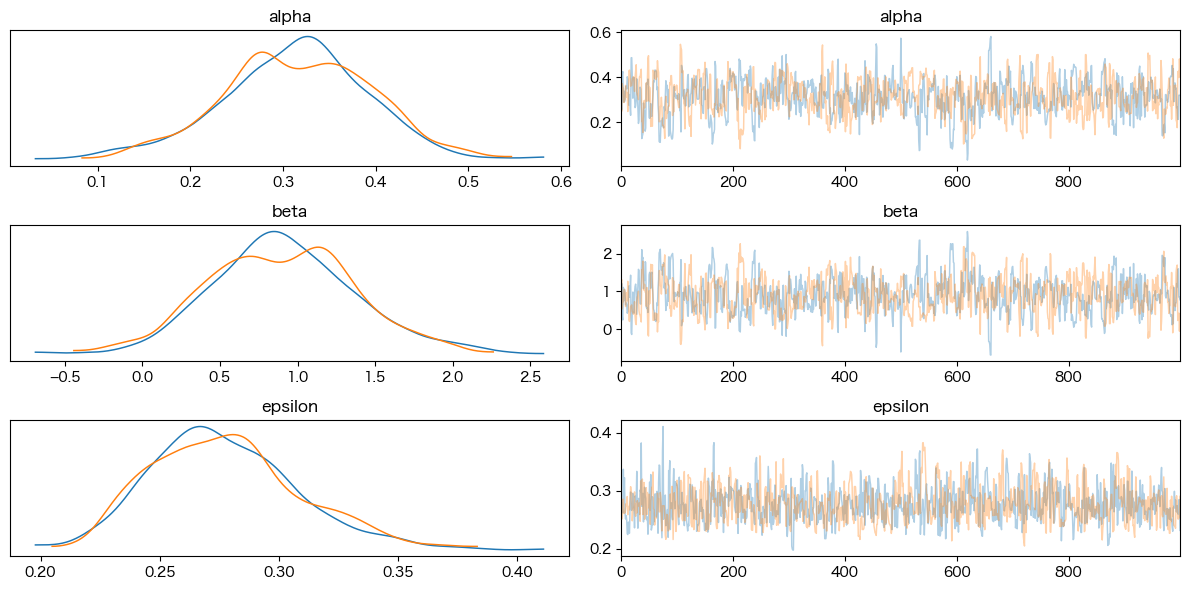

In [23]:
with model5:
    idata5 = pm.sample(random_seed=42, chains=2)

az.plot_trace(idata5, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

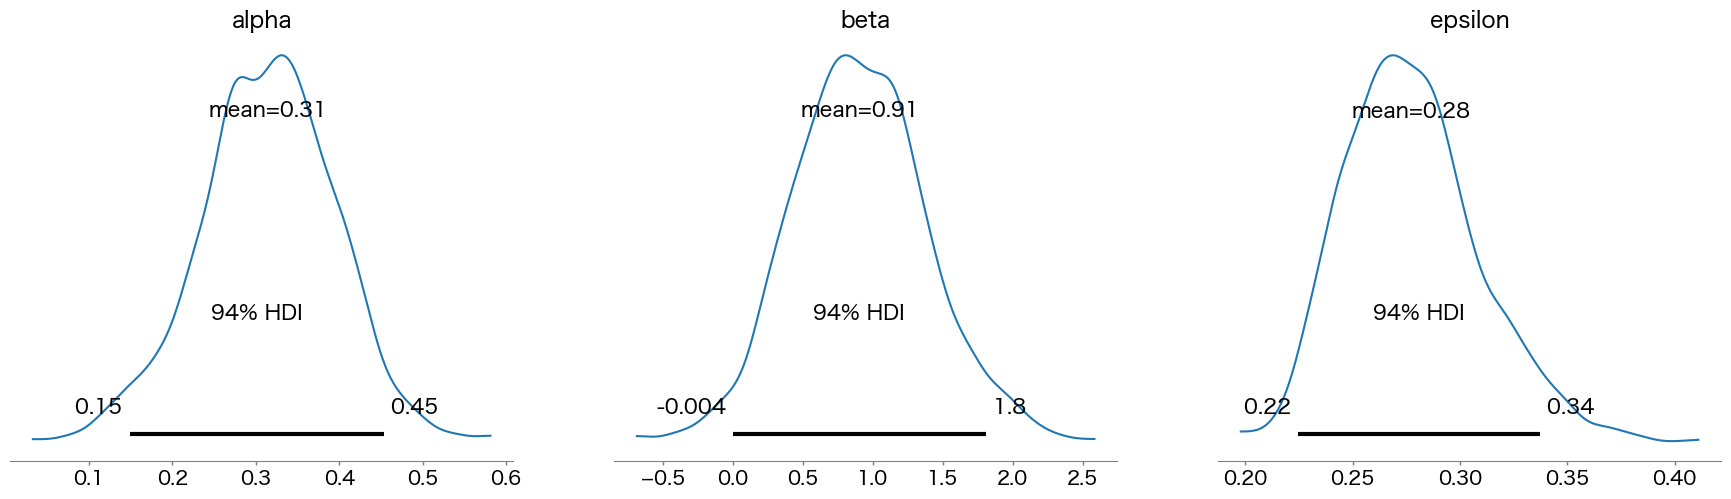

In [24]:
az.plot_posterior(idata5, var_names=["alpha", "beta", "epsilon"])

## 散布図と回帰直線の重ね書き

In [25]:
x_values = np.array([X.min() - 0.1, X.max() + 0.1])
print(x_values, x_values.shape)

alphas5 = idata5["posterior"]["alpha"].to_numpy().reshape(-1, 1)
betas5 = idata5["posterior"]["beta"].to_numpy().reshape(-1, 1)

print(alphas5.shape, betas5.shape)

y_preds = x_values * alphas5 + betas5
print(y_preds.shape)

[4.8 7.1] (2,)
(2000, 1) (2000, 1)
(2000, 2)


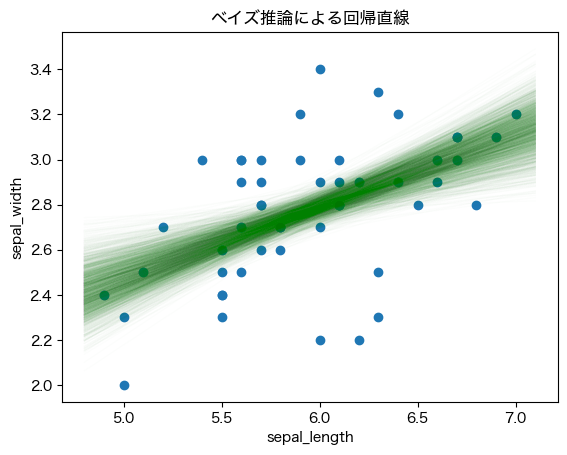

In [26]:
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")

plt.scatter(X, Y)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

## 少ない観測値でのベイズ推論

In [27]:
import random
random.seed(42)
indexes = range(len(X))
sample_indexes = random.sample(indexes, 3)
print("インデックス値", sample_indexes)

X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]

print("x の値", X_less.to_numpy())
print("y の値", Y_less.to_numpy())

インデックス値 [40, 7, 1]
x の値 [5.5 4.9 6.4]
y の値 [2.6 2.4 3.2]


Text(0, 0.5, 'sepal_width')

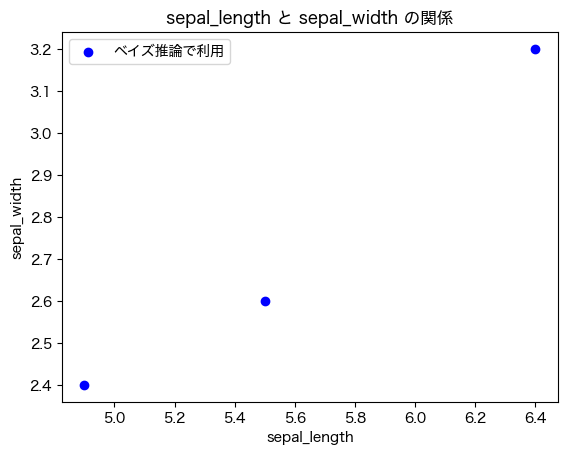

In [28]:
plt.title("sepal_length と sepal_width の関係")
plt.scatter(X_less, Y_less, label="ベイズ推論で利用", c="b", marker="o")
plt.legend()
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

In [29]:
with pm.Model() as model6:
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)
    mu = pm.Deterministic("mu", alpha * X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

    idata6 = pm.sample(random_seed=42, target_accept=0.995, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


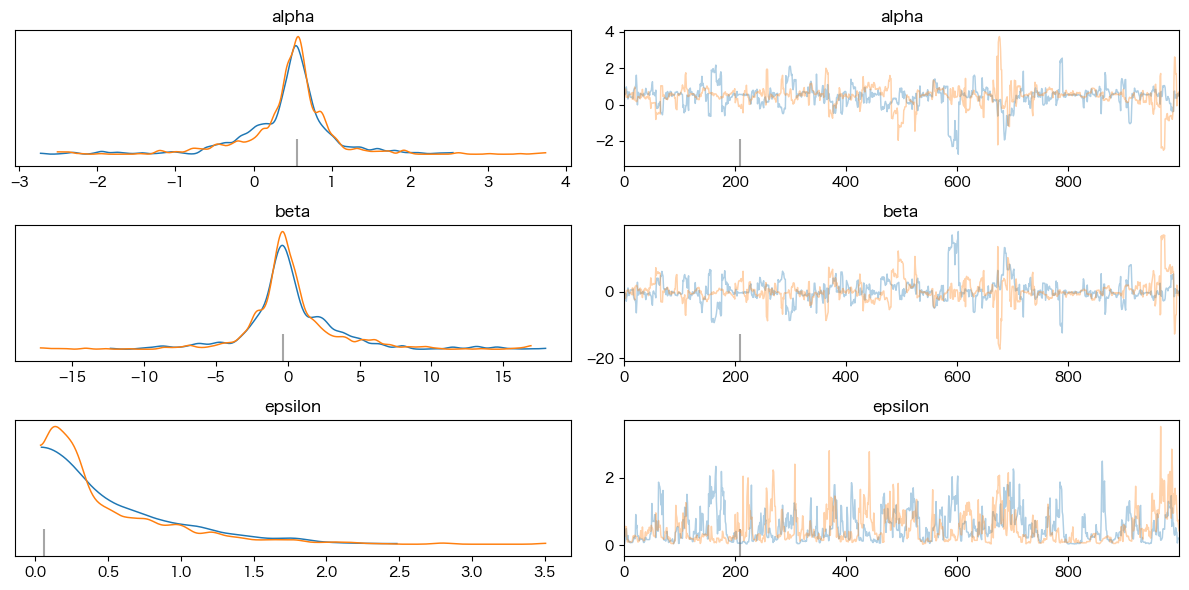

In [30]:
az.plot_trace(idata6, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [31]:
az.summary(idata6, var_names=["alpha", "beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.448,0.599,-0.649,1.628,0.041,0.029,235.0,178.0,1.00
beta,0.219,3.353,-6.246,6.746,0.234,0.189,235.0,174.0,1.00
epsilon,0.516,0.464,0.040,1.403,0.037,0.027,135.0,237.0,1.01


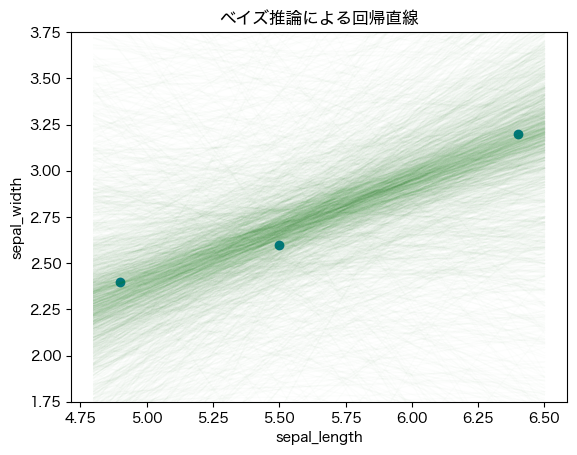

In [32]:
x_values = np.array([X_less.min() - 0.1, X_less.max() + 0.1])
alphas6 = idata6["posterior"]["alpha"].to_numpy().reshape(-1, 1)
betas6 = idata6["posterior"]["beta"].to_numpy().reshape(-1, 1)
y_preds = x_values * alphas6 + betas6

for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

## target_accept によるチューニング

In [33]:
with pm.Model() as model7:
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)
    mu = pm.Deterministic("mu", alpha * X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

    idata7 = pm.sample(random_seed=42, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


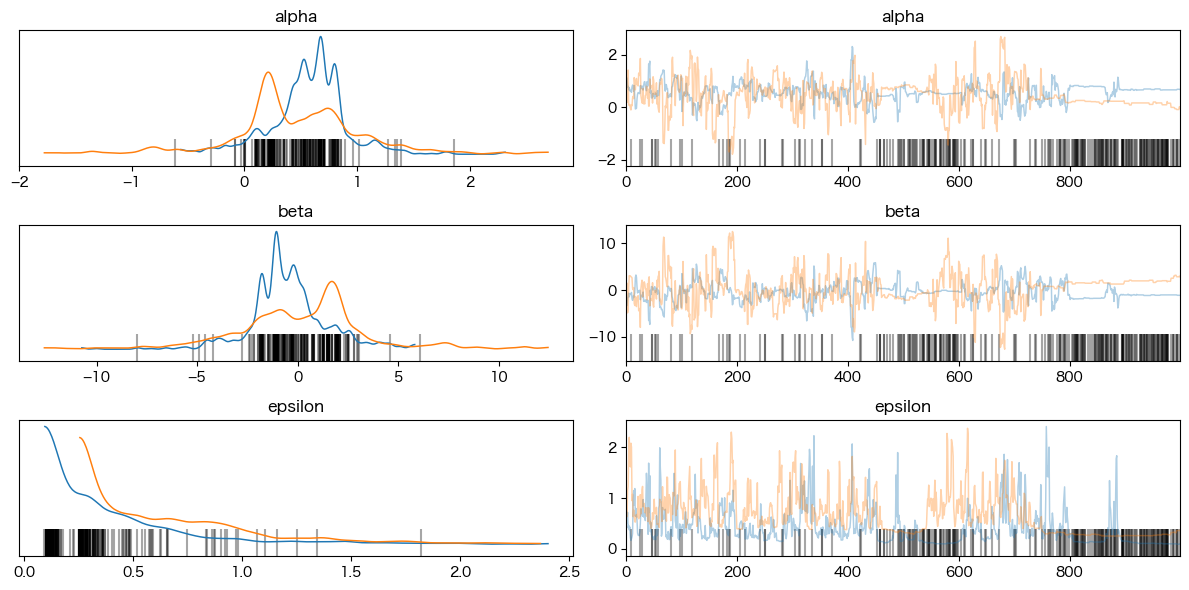

In [34]:
az.plot_trace(idata7, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [35]:
summary7 = az.summary(idata7, var_names=["alpha", "beta", "epsilon"])
display(summary7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.510,0.500,-0.517,1.430,0.037,0.030,128.0,295.0,1.09
beta,-0.130,2.785,-5.814,4.878,0.210,0.164,120.0,265.0,1.08
epsilon,0.538,0.407,0.101,1.352,0.120,0.087,7.0,13.0,1.24


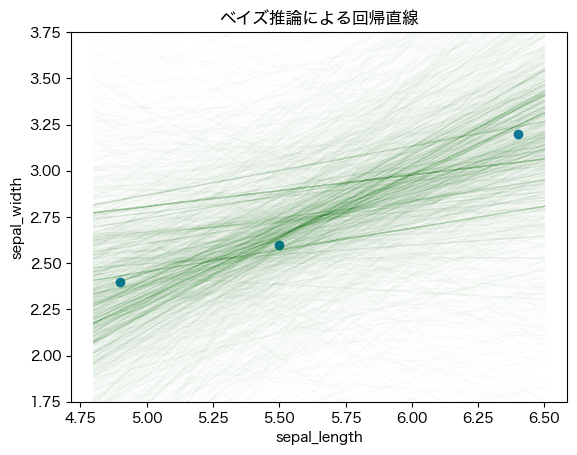

In [36]:
x_values = np.array([X_less.min() - 0.1, X_less.max() + 0.1])
alphas7 = idata7["posterior"]["alpha"].to_numpy().reshape(-1, 1)
betas7 = idata7["posterior"]["beta"].to_numpy().reshape(-1, 1)
y_preds = x_values * alphas7 + betas7

for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");